In [1]:
#Vinculamos el notebook con My Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from  sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import decomposition
import matplotlib.cm as cm # auxiliar para visualizar
from scipy.cluster.hierarchy import dendrogram, linkage 
 

In [3]:
intervenciones = pd.read_csv('/content/drive/My Drive/Data Science/intervenciones-de-seguridad-vial.csv')
intervenciones = intervenciones[intervenciones.condiciones_meteorologicas != '<SD>']
intervenciones.head(3)

,periodo,fecha,hora,autopista,banda_y_o_ramal,pk,condiciones_meteorologicas,superficie_de_la_via,lesionados,fallecidos,tipo_de_siniestro,moto,liviano,bus,camion
0,201401,2014-01-01,1,AU CAMPORA,ASCENDENTE,600,BUENO,SECA,1,0,COLISION CON OBSTACULO FIJO,0,1,0,0
1,201401,2014-01-01,3,AU DELLEPIANE,DESCENDENTE,600,BUENO,SECA,0,0,COLISION CON OBSTACULO FIJO,0,1,0,0
2,201401,2014-01-01,22,AU 25 DE MAYO,ASCENDENTE,5900,BUENO,SECA,8,0,COLISION CON DOS O MAS VEHICULOS,0,2,0,0


In [4]:
intervenciones['autopista'] = intervenciones['autopista'].replace(['AU PERTIO MORENO'],'AU PERITO MORENO')
intervenciones['autopista'] = intervenciones['autopista'].replace(['AV. CANTILO'],'AV CANTILO')
intervenciones['autopista'] = intervenciones['autopista'].replace(['AV. LUGONES'],'AV LUGONES')
intervenciones['condiciones_meteorologicas'] = intervenciones['condiciones_meteorologicas'].replace(['NIEBLA'],'NIEBLA, BRUMA O HUMO')


Creamos dummies con las columnas hora, autopista, condiciones_meteorologicas, superficie_de_la_via y tipo_de_siniestro. 

Eliminamos de cada dummie una columna ya que se puede hacer referencia a ella cuando el resto toma valores de 0.

In [5]:
hora_dummies = pd.get_dummies(intervenciones.hora)
hora_dummies = hora_dummies.drop([23], axis=1)

autopista_dummies = pd.get_dummies(intervenciones.autopista)
autopista_dummies = autopista_dummies.drop(['AU CAMPORA'], axis=1)

cond_meteorologicas_dummies = pd.get_dummies(intervenciones.condiciones_meteorologicas)
cond_meteorologicas_dummies = cond_meteorologicas_dummies.drop(['VIENTOS FUERTES'], axis=1)

sup_via_dummies = pd.get_dummies(intervenciones.superficie_de_la_via)
sup_via_dummies = sup_via_dummies.drop(['SECA'], axis=1)

tipo_siniestro_dummies = pd.get_dummies(intervenciones.tipo_de_siniestro)
tipo_siniestro_dummies =tipo_siniestro_dummies.rename(columns={"OTRO": "OTROS"})
tipo_siniestro_dummies = tipo_siniestro_dummies.drop(['SINIESTRO DE UN SOLO VEHICULO / SIN COLISION'], axis=1)


#Filtramos el dataset original con las features que vamos a utilizar para el cluster
X=intervenciones[['lesionados','fallecidos','moto','liviano','bus','camion']] 

#concatenamos dummies y x
X = pd.concat([X,hora_dummies, autopista_dummies, cond_meteorologicas_dummies, sup_via_dummies, tipo_siniestro_dummies], axis=1, sort=False)

X.head()

,lesionados,fallecidos,moto,liviano,bus,camion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,AU 25 DE MAYO,AU DELLEPIANE,AU FRONDIZI,AU ILLIA,AU PERITO MORENO,AV CANTILO,AV LUGONES,DIST. 9 DE JULIO,DIST. DELLEPIANE,DIST. UDAONDO,PASEO DEL BAJO,PTE. SCALABRINI ORTIZ,TRANSICION RAMAL 1,TRANSICION RAMAL 2,TRANSICION RAMAL 3,BUENO,LLUVIOSO,"NIEBLA, BRUMA O HUMO",INUNDADA,MOJADA/HUMEDA,OTRO,COLISION CON DOS O MAS VEHICULOS,COLISION CON OBSTACULO FIJO,CON DOS O MAS VEHICULOS-IMPACTO TRASERO,OBSTACULO NO FIJO,OTROS,OTRO TIPO DE SINIESTRO
0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,8,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [6]:
np.shape(X)

(6638, 56)

**_CLUSTERING CON K-MEANS_**

In [7]:
# Preprocesamos y nuestros datos pre-procesados los guardamos en "xscal"
scaler =preprocessing.StandardScaler().fit(X)
xscal = scaler.transform(X)  
xscal

array([[ 0.40664706, -0.08977382, -0.72262509, ..., -0.21945485,
        -0.06508461, -0.05896564],
       [-0.6154367 , -0.08977382, -0.72262509, ..., -0.21945485,
        -0.06508461, -0.05896564],
       [ 7.56123339, -0.08977382, -0.72262509, ..., -0.21945485,
        -0.06508461, -0.05896564],
       ...,
       [-0.6154367 , -0.08977382,  1.15699299, ..., -0.21945485,
        -0.06508461, -0.05896564],
       [ 0.40664706, -0.08977382, -0.72262509, ..., -0.21945485,
        -0.06508461, -0.05896564],
       [-0.6154367 , -0.08977382, -0.72262509, ..., -0.21945485,
        15.36461612, -0.05896564]])

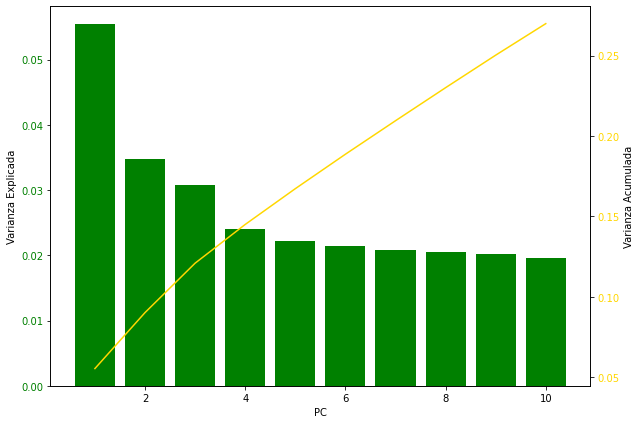

In [8]:
n_comps = 10
components = range(1,n_comps + 1) 
pca = decomposition.PCA(n_components=n_comps)

# Ajustamos
pca.fit(xscal)

# Transformamos
xpca = pca.transform(xscal)

# Porcentaje de la varianza explicada por cada PC
eigenvalues = pca.explained_variance_ratio_

# Suma acumulada
eigenvalues_acum = pca.explained_variance_ratio_.cumsum() 

# Graficamos
# Eje Izquierdo
fig, ax1 = plt.subplots(figsize=(9,6))
ax1.set_xlabel('PC')
ax1.set_ylabel('Varianza Explicada', color='k')
ax1.bar(components, eigenvalues, color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Eje derecho
ax2 = ax1.twinx()  
ax2.set_ylabel('Varianza Acumulada', color='k') 
ax2.plot(components, eigenvalues_acum, color='gold') 
ax2.tick_params(axis='y', labelcolor='gold')

fig.tight_layout()  
plt.show()

Con 10 componentes principales explicamos menos del 30% de la varianza, procedemos a reducir la dimensionalidad.

In [9]:
reduced_dim = 2
xpca_rd = xpca[:,0 :reduced_dim]
kmeans_rd = KMeans(n_clusters=2, random_state=10).fit(xpca_rd)
# una vez realizado el clustering, observamos las labels de cluster asignadas a cada muestra
kmeans_rd.labels_ = kmeans_rd.labels_

# visualizamos los centroides finales de cada cluster
centers_rd = kmeans_rd.cluster_centers_
centers_rd

array([[ 4.16763584,  0.78129169],
       [-0.62778221, -0.11768807]])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


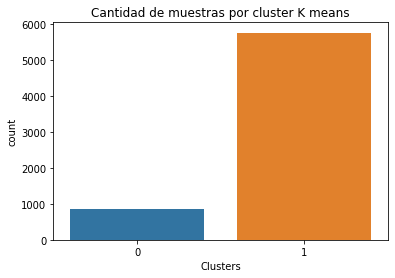

In [10]:
sns.countplot(kmeans_rd.labels_)
plt.title("Cantidad de muestras por cluster K means")
plt.xlabel("Clusters")
plt.show()

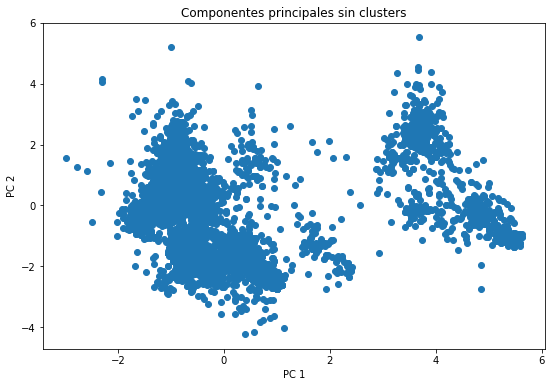

In [11]:
#Vizualizamos las componentes principales sin cluster
plt.figure(figsize=(9,6))
plt.scatter(xpca_rd[:,0],xpca_rd[:,1])    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Componentes principales sin clusters')
plt.show()

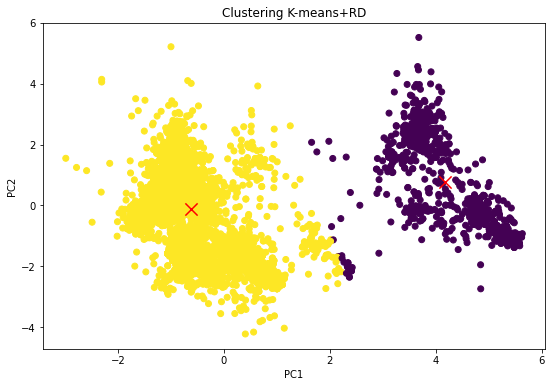

In [12]:
plt.figure(figsize=(9,6))
plt.scatter(xpca_rd[:,0],xpca_rd[:,1],c=kmeans_rd.labels_.astype(float))
plt.scatter(centers_rd[:,0], centers_rd[:,1], marker="x", color='r',s=150)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering K-means+RD')
plt.show()

In [13]:
sill_score_rd = silhouette_score(xpca_rd,kmeans_rd.labels_)
print("El silhoutte score es: " +str(sill_score_rd))

El silhoutte score es: 0.6504852134841351


**_CLUSTERING JERÁRQUICO_**

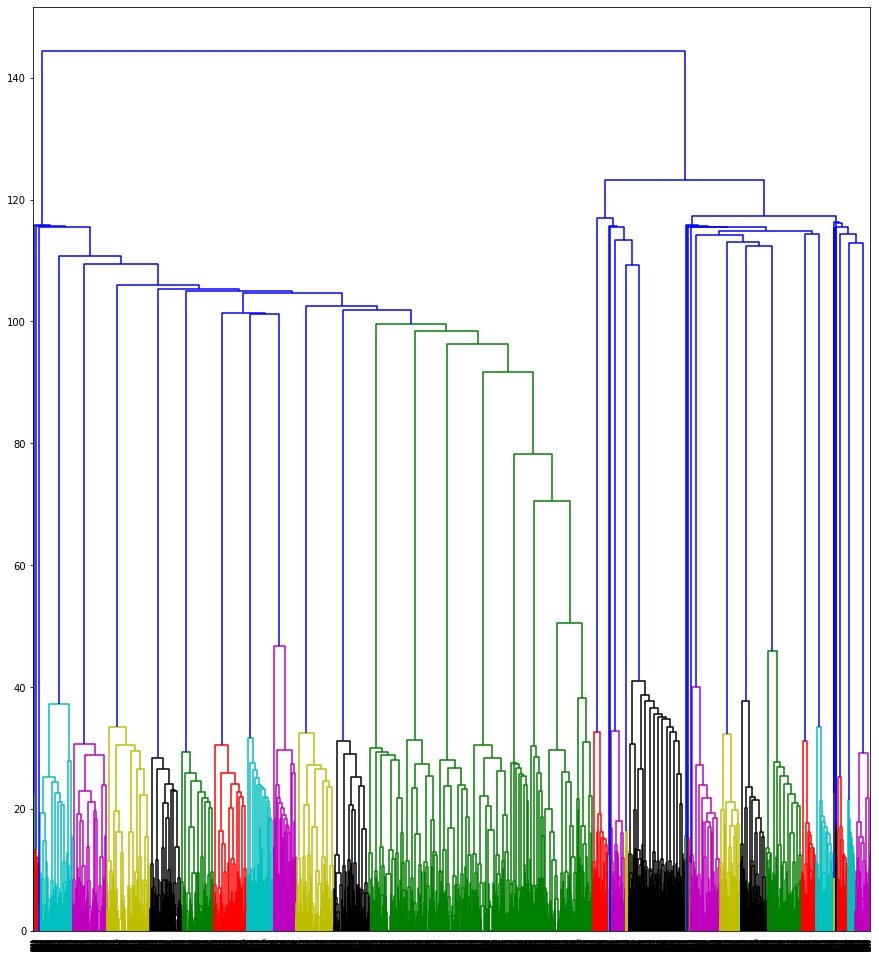

In [24]:
j = linkage(xscal, 'ward')
plt.figure(figsize=(15, 17))
dendrogram(j)
plt.show()

In [15]:
jerarquico = AgglomerativeClustering(n_clusters=2).fit(xscal)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


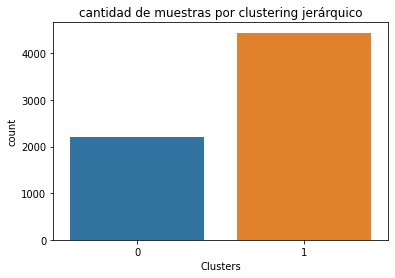

In [16]:
sns.countplot(jerarquico.labels_)
plt.title("cantidad de muestras por clustering jerárquico")
plt.xlabel("Clusters")
plt.show()

In [17]:
sill_score_jerarquico = silhouette_score(xscal,jerarquico.labels_)
print("El silhoutte score es: " +str(sill_score_jerarquico))

El silhoutte score es: 0.11270783620172925


In [18]:
resultados = pd.DataFrame(columns=['Cluster','Silhouette'])
resultados = resultados.append({'Cluster':'Kmeans+RD',
                                'Silhouette':sill_score_rd},ignore_index=True)
resultados = resultados.append({'Cluster':'Jerarquico',
                                'Silhouette':sill_score_jerarquico},ignore_index=True)
resultados


,Cluster,Silhouette
0,Kmeans+RD,0.650485
1,Jerarquico,0.112708


Conclusión parcial:
el método K-means agrupó por amplia mayoría las muestras en el cluster 1, mientras que en el jerárquico, a pesar de mantener esta mayoría, el cluster 0 duplicó (y más) su cantidad respecto al método anterior. 
Por otro lado, el Kmeans+RD tiene un Silhouette Score muy por encima del método Jerárquico, por lo tanto procedemos a analizar los clusters obtenidos por este método.

In [19]:
#Agregamos la matriz con las labels obtenidas a nuestro dataset
X['labels'] = kmeans_rd.labels_
X.head(2)

,lesionados,fallecidos,moto,liviano,bus,camion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,AU 25 DE MAYO,AU DELLEPIANE,AU FRONDIZI,AU ILLIA,AU PERITO MORENO,AV CANTILO,AV LUGONES,DIST. 9 DE JULIO,DIST. DELLEPIANE,DIST. UDAONDO,PASEO DEL BAJO,PTE. SCALABRINI ORTIZ,TRANSICION RAMAL 1,TRANSICION RAMAL 2,TRANSICION RAMAL 3,BUENO,LLUVIOSO,"NIEBLA, BRUMA O HUMO",INUNDADA,MOJADA/HUMEDA,OTRO,COLISION CON DOS O MAS VEHICULOS,COLISION CON OBSTACULO FIJO,CON DOS O MAS VEHICULOS-IMPACTO TRASERO,OBSTACULO NO FIJO,OTROS,OTRO TIPO DE SINIESTRO,labels
0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [20]:
#Separamos en 2 tablas, una para las label 0 y otra para las label 1
cluster0 = X.loc[X.labels == 0]
cluster1 = X.loc[X.labels == 1]


In [21]:
#Visualizamos datos estadisticos
cluster0.describe()

,lesionados,fallecidos,moto,liviano,bus,camion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,AU 25 DE MAYO,AU DELLEPIANE,AU FRONDIZI,AU ILLIA,AU PERITO MORENO,AV CANTILO,AV LUGONES,DIST. 9 DE JULIO,DIST. DELLEPIANE,DIST. UDAONDO,PASEO DEL BAJO,PTE. SCALABRINI ORTIZ,TRANSICION RAMAL 1,TRANSICION RAMAL 2,TRANSICION RAMAL 3,BUENO,LLUVIOSO,"NIEBLA, BRUMA O HUMO",INUNDADA,MOJADA/HUMEDA,OTRO,COLISION CON DOS O MAS VEHICULOS,COLISION CON OBSTACULO FIJO,CON DOS O MAS VEHICULOS-IMPACTO TRASERO,OBSTACULO NO FIJO,OTROS,OTRO TIPO DE SINIESTRO,labels
count,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.0,869.0,869.000000,869.000000,869.0,869.000000,869.0,869.000000,869.000000,869.000000,869.000000,869.000000,869.0,869.000000,869.000000,869.0,869.000000,869.000000,869.000000,869.0
mean,0.433832,0.003452,0.194476,1.309551,0.036824,0.105869,0.029919,0.046030,0.040276,0.017261,0.039125,0.033372,0.074799,0.067894,0.056387,0.028769,0.048331,0.036824,0.032221,0.035673,0.037975,0.046030,0.035673,0.046030,0.047181,0.044879,0.047181,0.042578,0.036824,0.295742,0.133487,0.118527,0.044879,0.220944,0.073648,0.092060,0.003452,0.0,0.0,0.001151,0.001151,0.0,0.004603,0.0,0.019563,0.966628,0.011507,0.001151,0.990794,0.0,0.463751,0.391254,0.0,0.034522,0.009206,0.003452,0.0
std,0.824066,0.058688,0.418651,0.967044,0.194456,0.356409,0.170463,0.209671,0.196719,0.130318,0.194005,0.179709,0.263218,0.251709,0.230800,0.167252,0.214589,0.188438,0.176688,0.185581,0.191245,0.209671,0.185581,0.209671,0.212147,0.207158,0.212147,0.202019,0.188438,0.456638,0.340296,0.323417,0.207158,0.415121,0.261347,0.289277,0.058688,0.0,0.0,0.033923,0.033923,0.0,0.067728,0.0,0.138572,0.179709,0.106715,0.033923,0.095560,0.0,0.498971,0.488312,0.0,0.182672,0.095560,0.058688,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
75%,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,1.000

In [22]:
cluster1.describe()

,lesionados,fallecidos,moto,liviano,bus,camion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,AU 25 DE MAYO,AU DELLEPIANE,AU FRONDIZI,AU ILLIA,AU PERITO MORENO,AV CANTILO,AV LUGONES,DIST. 9 DE JULIO,DIST. DELLEPIANE,DIST. UDAONDO,PASEO DEL BAJO,PTE. SCALABRINI ORTIZ,TRANSICION RAMAL 1,TRANSICION RAMAL 2,TRANSICION RAMAL 3,BUENO,LLUVIOSO,"NIEBLA, BRUMA O HUMO",INUNDADA,MOJADA/HUMEDA,OTRO,COLISION CON DOS O MAS VEHICULOS,COLISION CON OBSTACULO FIJO,CON DOS O MAS VEHICULOS-IMPACTO TRASERO,OBSTACULO NO FIJO,OTROS,OTRO TIPO DE SINIESTRO,labels
count,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.0,5769.0,5769.0,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.000000,5769.0
mean,0.627492,0.009014,0.413070,1.187034,0.036748,0.158086,0.015774,0.014734,0.015774,0.011787,0.016467,0.020454,0.043682,0.060149,0.061882,0.071590,0.057549,0.047669,0.049575,0.058762,0.061189,0.054082,0.051309,0.062923,0.067949,0.046975,0.035361,0.031201,0.024614,0.306812,0.168660,0.096031,0.057376,0.192408,0.054082,0.098804,0.003467,0.000347,0.000347,0.002253,0.000693,0.000173,0.002253,0.005200,0.999827,0.0,0.0,0.0,0.035881,0.002600,0.658000,0.171780,0.000173,0.047669,0.003467,0.003467,1.0
std,0.997264,0.096337,0.541396,0.989647,0.199779,0.424179,0.124611,0.120496,0.124611,0.107936,0.127275,0.141560,0.204404,0.237783,0.240963,0.257829,0.232909,0.213082,0.217085,0.235200,0.239698,0.226199,0.220646,0.242845,0.251681,0.211604,0.184708,0.173876,0.154960,0.461211,0.374484,0.294659,0.232579,0.394226,0.226199,0.298424,0.058783,0.018618,0.018618,0.047421,0.026325,0.013166,0.047421,0.071931,0.013166,0.0,0.0,0.0,0.186011,0.050929,0.474421,0.377222,0.013166,0.213082,0.058783,0.058783,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00

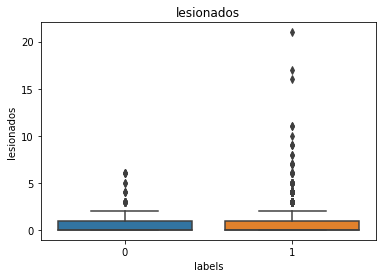

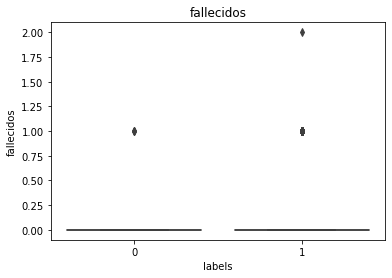

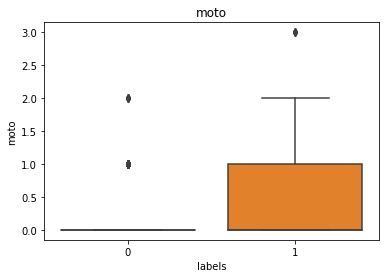

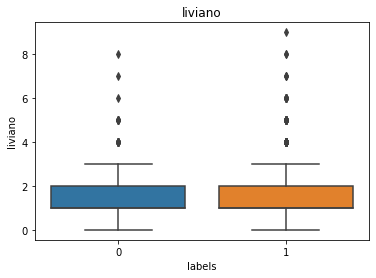

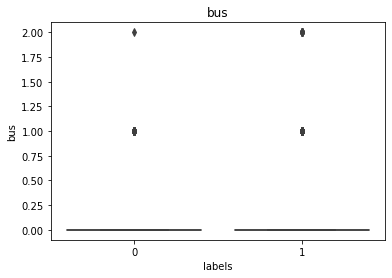

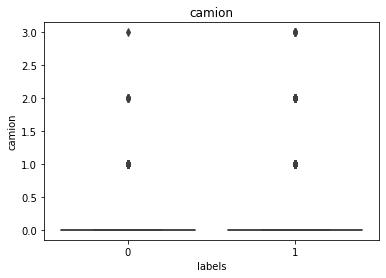

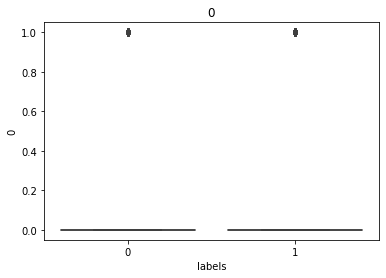

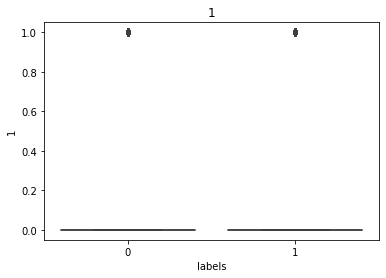

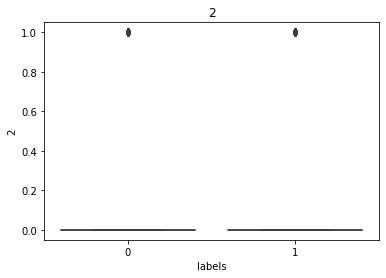

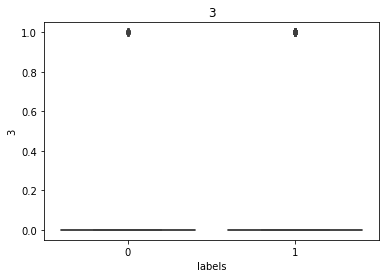

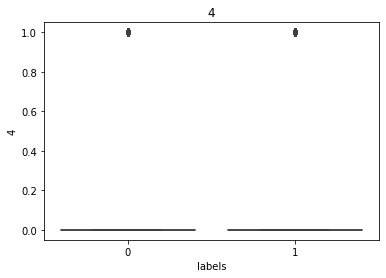

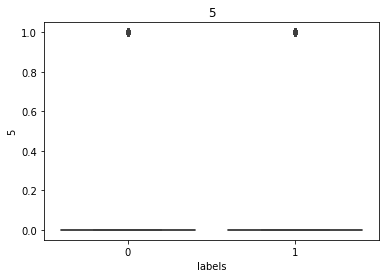

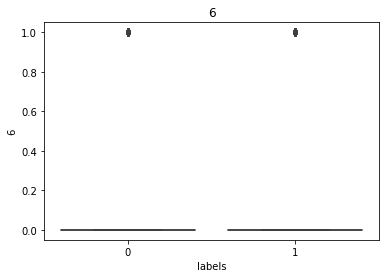

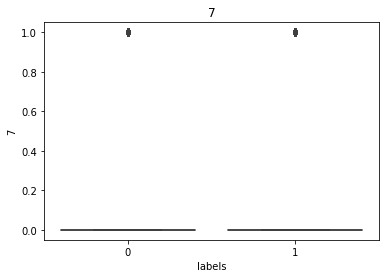

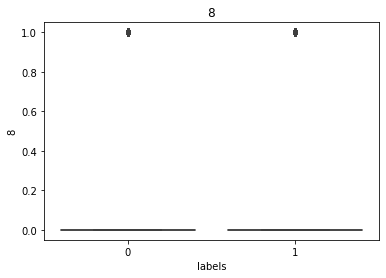

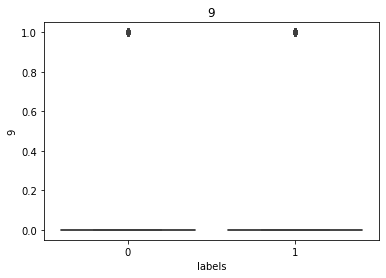

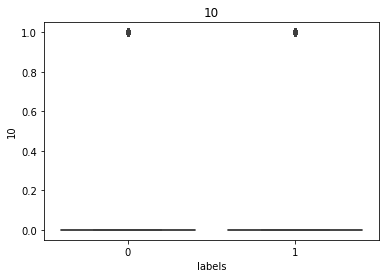

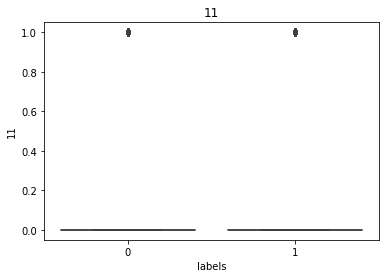

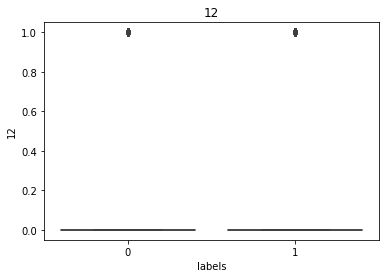

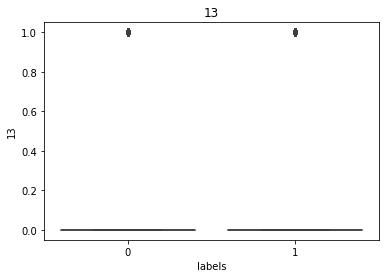

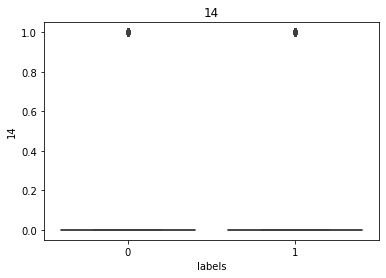

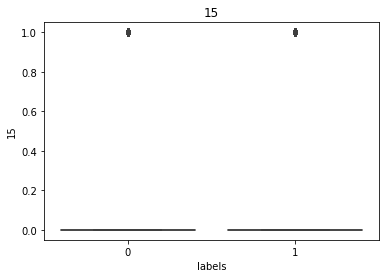

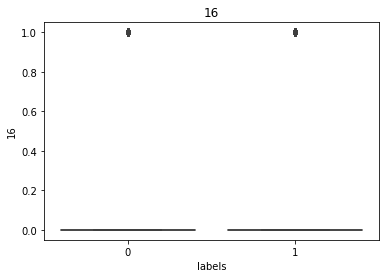

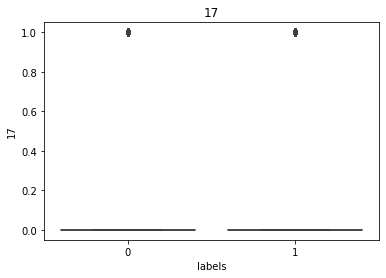

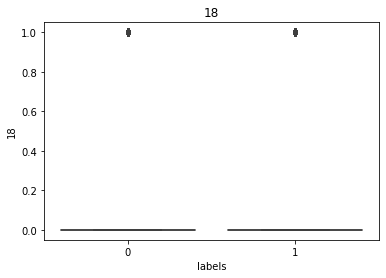

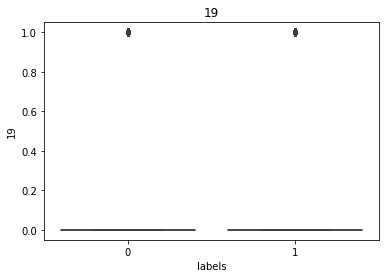

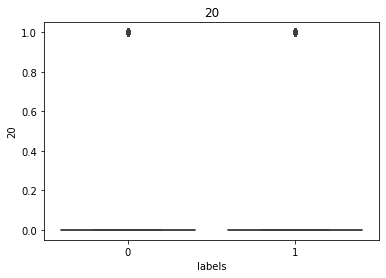

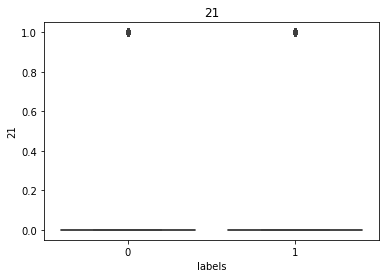

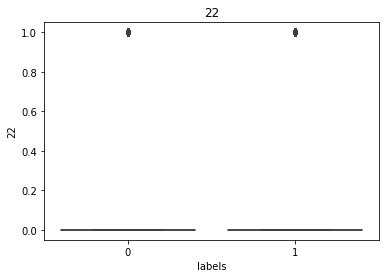

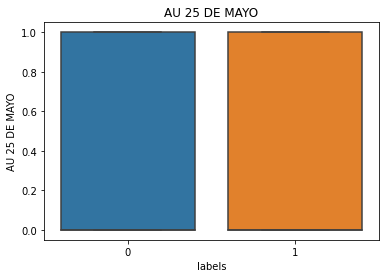

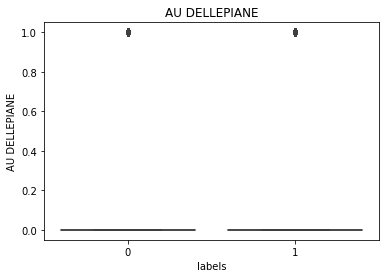

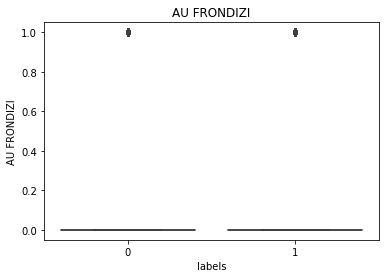

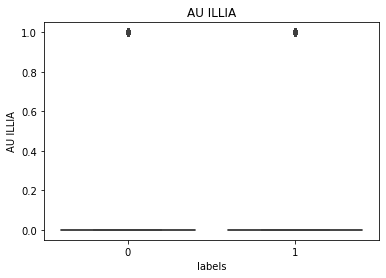

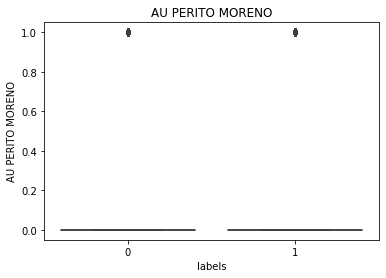

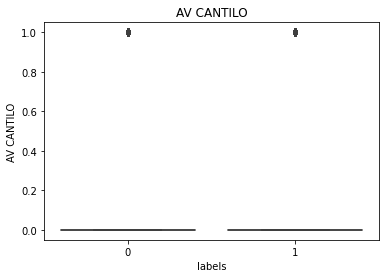

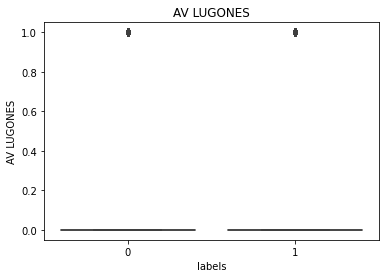

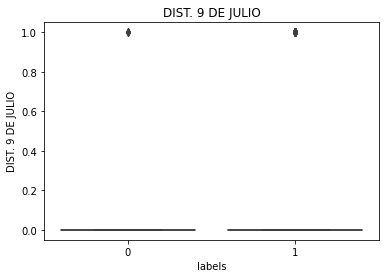

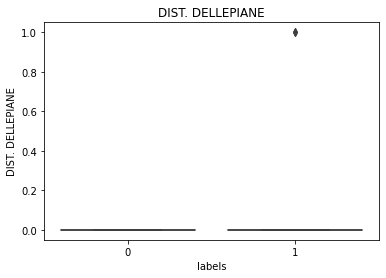

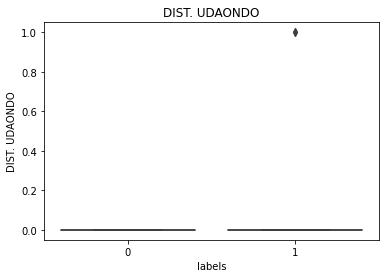

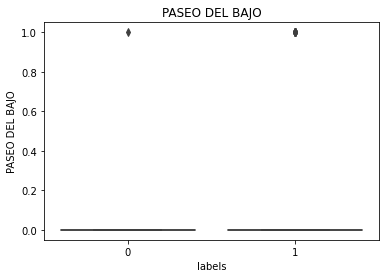

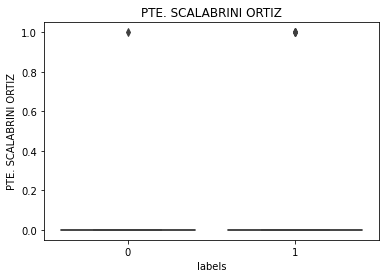

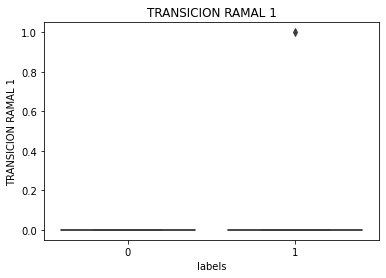

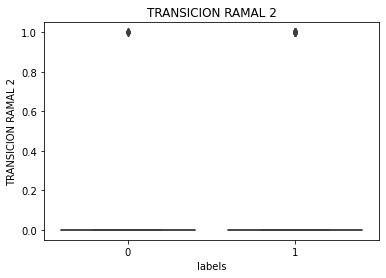

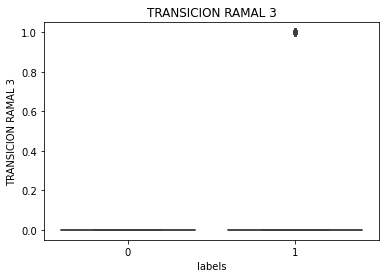

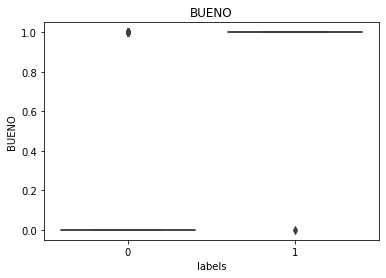

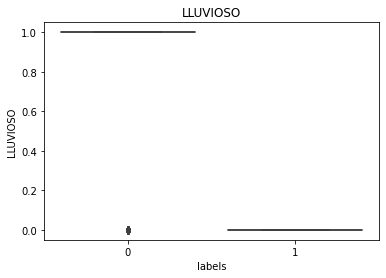

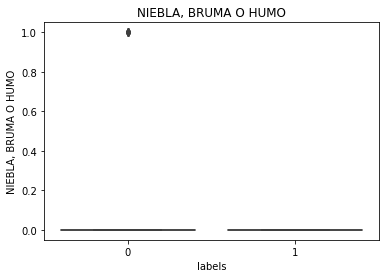

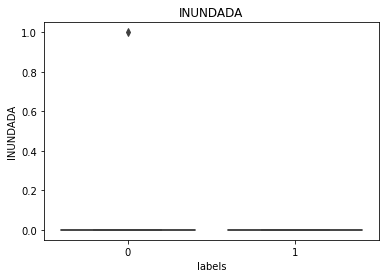

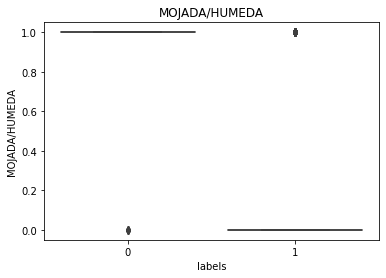

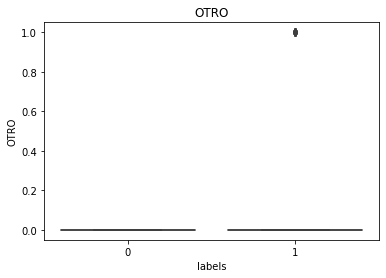

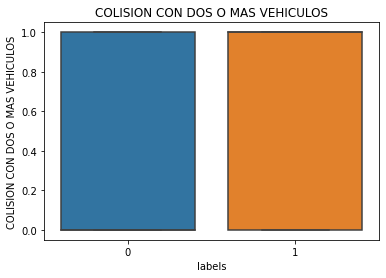

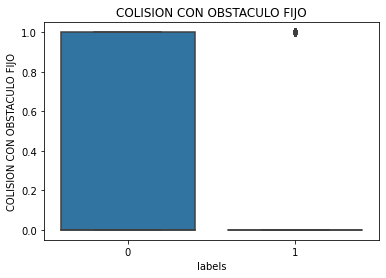

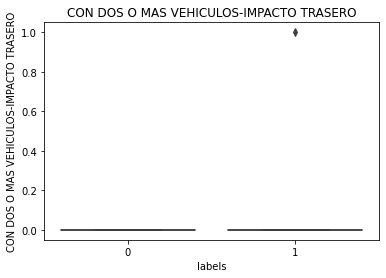

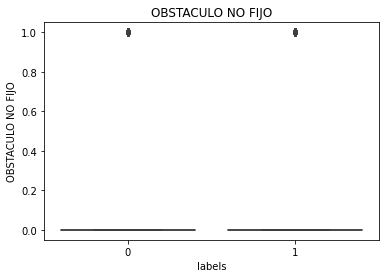

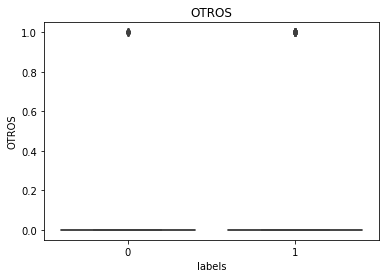

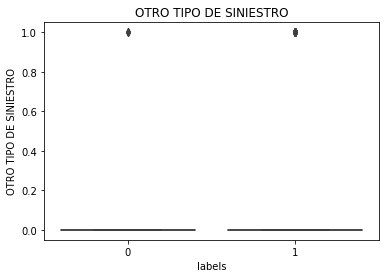

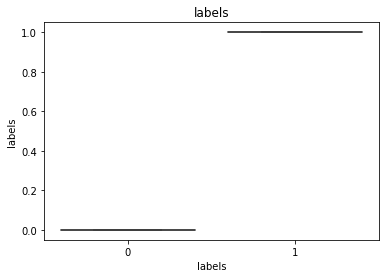

In [23]:
#Realizamos boxplots para cada columna
for x in range(0,len(X.columns)):
    
    plt.figure()
    plt.title(X.columns[x])
    ax = sns.boxplot(x = "labels", y = X.columns[x], data =  X)
    plt.show()

##_**CONCLUSIONES CLUSTERS**_ 

-Se puede visualizar en los graficos que en el cluster 0 compuesto por casi todas las samples (5769) predomina ampliamente clima bueno con una media de 0.999827, mientras que en el cluster 1 compuesto por la minoria (869) predomina el clima lluvioso con una media de 0.966628 y el estado de la ruta mojada/humeda. Es un factor clave para realizar la agrupacion.

-Podemos observar que la cantidad de lesionados se distribuye en una proporcion similar en ambos clusters. En el cluster 0 tiene un poco mas de outliers, lo que nos marca que hay dias particulares con mas lesionados que en el cluster 1.

-Al igual que los lesionados, los fallecidos tambien estan distribuidos en ambos clusters con igual proporcion. 

-Las intervenciones con motos ocurren en el cluster 0.

-Las intervenciones con vehiculos livianos estan distribuidos en ambos clusters, al igual que bus y camion.

-Casi la totalidad de las intervenciones se dan en la autopista 25 de mayo, la cual creemos una variable critica. Esto refleja el resultado que obtuvimos con el countplot realizado en el EDA. 
Los casos se distribuyen de igual manera en los dos clusters.

-Los tipos de accidentes que mas se dan en ambos clusters son de colision entre 2 o mas vehiculos.

-En el cluster 1 los mismos colisionan con obtaculos fijos, mientras que en el cluster 0 no. Esto puede estar relacionado con el clima predominante en cada cluster.
